In [0]:
!pip install Pillow==4.1.1
!pip install "fastai==0.7.0"
!pip install torchtext==0.2.3



%matplotlib inline
!pip install kaggle

In [0]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import feather

In [0]:
!mkdir -p ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/


In [0]:
!pip install pyarrow==0.10.0

In [0]:
!kaggle competitions download -c favorita-grocery-sales-forecasting -p data

In [0]:
PATH = "data/"

In [0]:
!apt-get install p7zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
!ls data/

holidays_events.csv.7z	sample_submission.csv.7z  train.csv.7z
items.csv.7z		stores.csv.7z		  transactions.csv.7z
oil.csv.7z		test.csv.7z


In [0]:
!7z x data/train.csv.7z

In [0]:
types = {'id': 'int64',
         'item_nbr': 'int32',
         'store_nbr': 'int8',
         'unit_sales': 'float32',
         'onpromotion': 'object'}  # general purpose object

In [0]:
%%time
%prun 
df_all = pd.read_csv(f'train.csv', parse_dates=['date'], 
                     dtype=types, infer_datetime_format=True, low_memory = True)

 CPU times: user 2min 18s, sys: 13.8 s, total: 2min 32s
Wall time: 4min 47s


In [0]:
df_all.describe(include ='all')

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
count,1.254970e+08,125497040,1.254970e+08,1.254970e+08,1.254970e+08,103839389
unique,NaN,1684,NaN,NaN,NaN,2
top,NaN,2017-07-01 00:00:00,NaN,NaN,NaN,False
freq,NaN,118194,NaN,NaN,NaN,96028767
first,NaN,2013-01-01 00:00:00,NaN,NaN,NaN,NaN
last,NaN,2017-08-15 00:00:00,NaN,NaN,NaN,NaN
mean,6.274852e+07,NaN,2.746458e+01,9.727692e+05,8.554856e+00,NaN
std,3.622788e+07,NaN,1.633051e+01,5.205336e+05,2.360515e+01,NaN
min,0.000000e+00,NaN,1.000000e+00,9.699500e+04,-1.537200e+04,NaN
25%,3.137426e+07,NaN,1.200000e+01,5.223830e+05,2.000000e+00,NaN


In [0]:

df_all.onpromotion.fillna(False, inplace=True)
df_all.onpromotion = df_all.onpromotion.map({'False': False, # replace string ‘True’ and ‘False’ with actual booleans.
                                             'True': True})
df_all.onpromotion = df_all.onpromotion.astype(bool) #  Then finally convert it to boolean type.
%time df_all.to_feather('tmp/raw_groceries')

CPU times: user 4.91 s, sys: 3.28 s, total: 8.19 s
Wall time: 1min 21s


In [0]:
# %time df_all.describe(include='all')


df_all = feather.read_dataframe('tmp/raw_groceries')


Find what dates are related to data and what test dates are given make sure they dont overlap

In [0]:
 # feather.read_dataframe('tmp/raw_groceries')

In [0]:
 !7z x data/test.csv.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 4885065 bytes (4771 KiB)

Extracting archive: data/test.csv.7z
--
Path = data/test.csv.7z
Type = 7z
Physical Size = 4885065
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%     16% - test.csv                39% - test.csv                63% - test.csv                86% - test.csv                99% - test.csv               Everything is Ok

Size:       126163026
Compressed: 4885065


In [0]:
df_test = pd.read_csv(f'test.csv', parse_dates = ['date'],
                      dtype=types, infer_datetime_format=True)
df_test.onpromotion.fillna(False, inplace=True)
df_test.onpromotion = df_test.onpromotion.map({'False': False, 
                                               'True': True})
df_test.onpromotion = df_test.onpromotion.astype(bool)

# df_test.describe(include='all')

In [0]:
df_test.to_feather('tmp/groceries_test')

In [0]:
feather.read_dataframe('tmp/groceries_test')

If you want to use a smaller dataset, we should use the most recent
—  not random set.

In [0]:
df_all.tail()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
125497035,125497035,2017-08-15,54,2089339,4.0,False
125497036,125497036,2017-08-15,54,2106464,1.0,True
125497037,125497037,2017-08-15,54,2110456,192.0,False
125497038,125497038,2017-08-15,54,2113914,198.0,True
125497039,125497039,2017-08-15,54,2116416,2.0,False


In [0]:
df_all.unit_sales = np.log(np.clip(df_all.unit_sales, 0, None)) +1
# log of the value plus 1. The competition detail tells you that they are 

# going to use root mean squared log plus 1 error because log(0) does not make sense.

# if there are -ve sales they are returns make 'em 0 using np.clip it clips to specified 
# min and max

# taking log as it is the selection criteria


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [0]:
%time add_datepart(df_all, 'date')

In [0]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

In [0]:
n_valid = len(df_test)
n_trn = len(df_all) - n_valid
train, valid = split_vals(df_all, n_trn)
train.shape, valid.shape

((122126576, 6), (3370464, 6))

In [0]:
%%time
trn, y, nas  = proc_df(train, 'unit_sales')
val, y_val, nas = proc_df(valid, 'unit_sales', nas)

In [0]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())
def print_score(m):
    res = [rmse(m.predict(X_train), y_train),
           rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [0]:
#set sample space of 1M data values there are 120M in total
set_rf_samples(1_000_000)

In [0]:
%time x = np.array(trn, dtype=np.float32)   // saving time everytime randomforest is called as this is done in randomforestregressor immediately 

In [0]:
??set_rf_samples

# BlueBook Work

##Interpreting machine learning models

In [0]:
df_raw = feather.read_dataframe('tmp/raw')

In [0]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [0]:
# creating a validation set

def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [0]:
df_raw

We now need to also find the confidence of our predictions so we use 
standard deviation; larger the no. more will be the difference in predictions
the more trees have seen the row, the better the trees predictions would be
so this is the least relative understanding of how confident we are of this 
prediction

In [0]:
set_rf_samples(50000)



In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                        max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

NameError: ignored

In [0]:
# storing predictions This one does not work parallely hence does not use 
# multiple cores use lower one

%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.61 s, sys: 115 ms, total: 1.72 s
Wall time: 1.73 s


(9.279061724222505, 0.3543483129345445)

In [0]:
# this one using fxn uses parallelism
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds)) # it takes model trained and 
# a function to call returns a list applying fxn to every tree
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 140 ms, sys: 645 ms, total: 785 ms
Wall time: 2.04 s


(9.295992875723705, 0.2989756948509729)

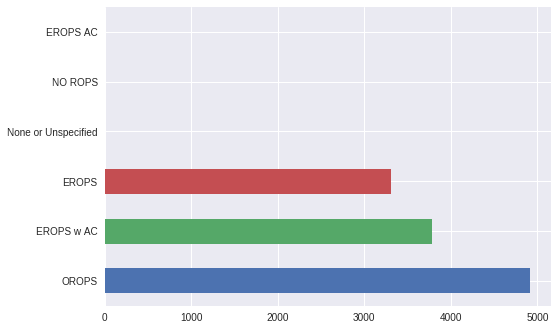

In [0]:
# We will first create a copy of the data and 
# add the standard deviation of the predictions
# and predictions mean as new columns:

x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [0]:
# here 3 fields are non existent so we only take 3 fields 

flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

# Prediction and the sale price are close to each other on average (good sign)
# Standard deviation varies a little bit

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.838863,0.275640
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.576466,0.264304
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.681466,0.224135


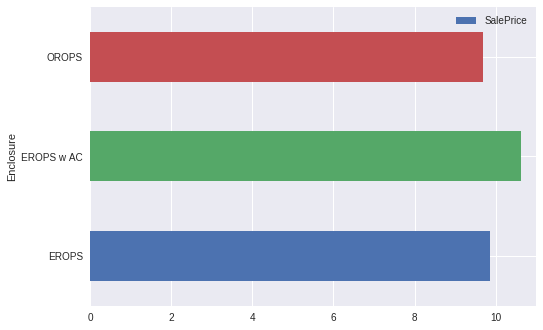

In [0]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

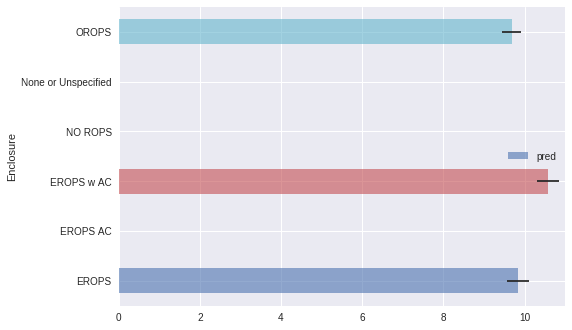

In [0]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', 
              alpha=0.6, xlim=(0,11));

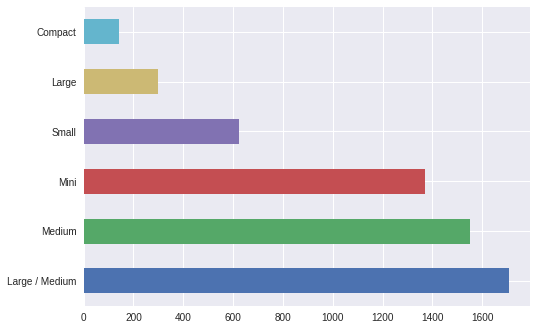

In [0]:
raw_valid.ProductSize.value_counts().plot.barh();
# using std deviation to predict error bars which will tell us confidence


In [0]:
# You expect, on average, when you are predicting something that is a bigger number 
# your standard deviation would be higher. So you can sort by the ratio of the standard 
# deviation of the predictions to the predictions themselves 
(summ.pred_std/summ.pred).sort_values(ascending=False)


ProductSize
Large             0.035004
Compact           0.034133
Small             0.030628
Large / Medium    0.027864
Medium            0.026961
Mini              0.025660
dtype: float64

In [0]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.837699,0.335794
Large,10.470589,10.384845,0.363507
Large / Medium,10.691871,10.655486,0.296908
Medium,10.681511,10.620536,0.286341
Mini,9.535147,9.562101,0.245365
Small,10.324448,10.319049,0.316055


In [0]:
# You expect, on average, when you are predicting something that is a bigger number
# your standard deviation would be higher. 
# So you can sort by the ratio of the standard deviation of the predictions to 
# the predictions themselves 

(summ.pred_std/summ.pred).sort_values(ascending=False)

'''
What this tells us is that product size Large and Compact , 
our predictions are less accurate (relatively speaking as a ratio of the total price). 
So if we go back and have a look, you see why. These are the smallest groups in the histogram. 
As you would expect, in small groups, we are doing a less good job.

You can use this confidence interval for two main purposes:

You can look at the average confidence interval by group to find out if there are 
groups you do not seem to have confidence about.

Perhaps more importantly, you can look at them for specific rows. 
When you put it in production, you might always want to see the confidence interval. 
For example, if you are doing credit scoring to decide whether to give somebody a loan, 
you probably want to see not only what their level of risk is but how confident we are. 
If they want to borrow lots of money and we are not at all confident about our ability 
to predict whether they will pay back, we might want to give them a smaller loan

'''


ProductSize
Large             0.035004
Compact           0.034133
Small             0.030628
Large / Medium    0.027864
Medium            0.026961
Mini              0.025660
dtype: float64

## feature importance :  Build a random forest make it better than random and then do feature importance

In [0]:
'''
fastai fxn takes in model m and dataframe 
returns pandas dataframe showing order of
importance

'''

fi = rf_feat_importance(m, df_trn); fi[:10]


,cols,imp
5,YearMade,0.173243
37,Coupler_System,0.118625
13,ProductSize,0.102994
14,fiProductClassDesc,0.073830
2,ModelID,0.052761
63,saleElapsed,0.050283
10,fiSecondaryDesc,0.043942
38,Grouser_Tracks,0.043899
19,Enclosure,0.040314
8,fiModelDesc,0.032886


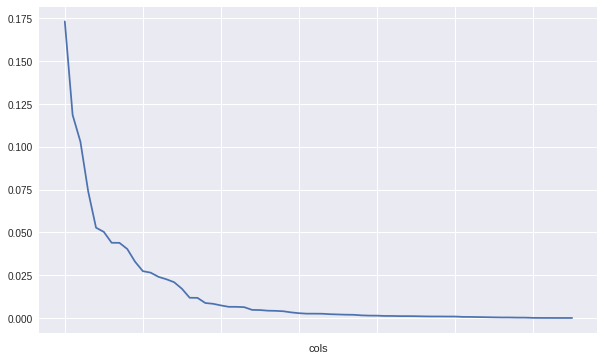

In [0]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

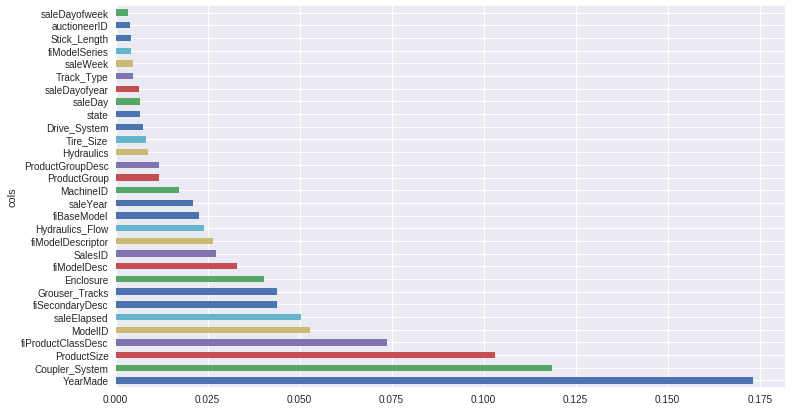

In [0]:
# plotting all important values
def plot_fi(fi): 
  return fi.plot('cols','imp','barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [0]:
'''
now we try to filter our data to see some changes that may occur after removal of
unnecessary values removing values below .005
'''
to_keep = fi[fi.imp>0.005].cols; len(to_keep)
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                       max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
#print_score(m)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

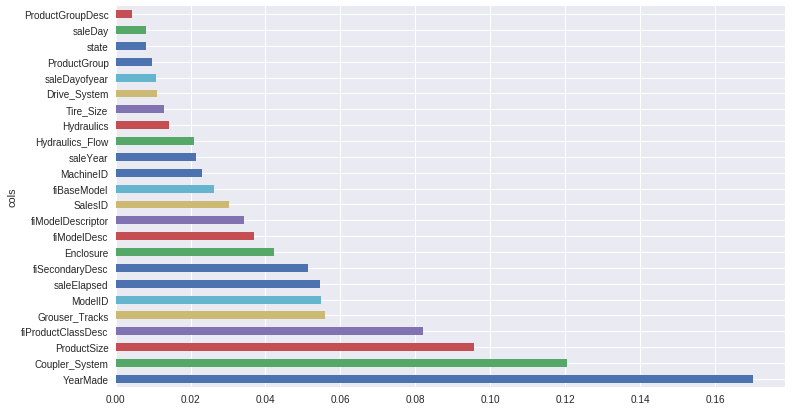

In [0]:
# rerun feature importance on updated values
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

'''
this will remove some columns and hence remove collinearity
there will be less collinearity to confuse us now as we now know
there are multiple things collinear with YearMade

'''

In [0]:
# now we can find out importance of the column by first finding our values and 
# comparing it with original values to get an idea then shuffling only that column 
# which we think is imp and training model again if r^2 decreases significantly 
# then the colm is important same can be done for a couple of colms